In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Import df
mean_df = pd.read_pickle("merged_df.pkl")

target_cols = ['cooler_condition', 'valve_condition', 'pump_leakage', 
               'hydraulic_accumulator', 'stable_flag']

feature_df = mean_df[[col for col in mean_df.columns if col not in target_cols]]
target_df = mean_df[target_cols]

# Data correlations

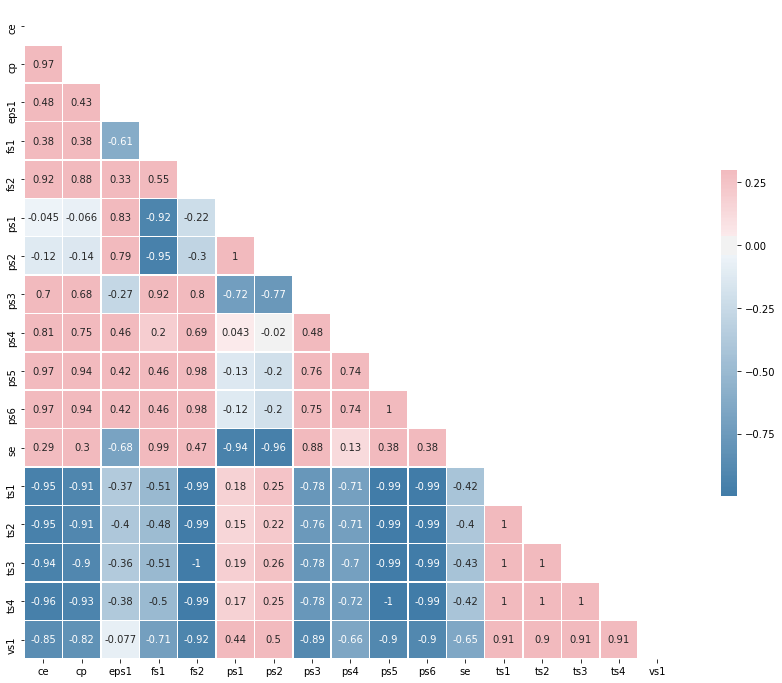

In [3]:
# Sensor data correlation
f, ax = plt.subplots(figsize=(16, 12))
corr = feature_df.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(corr,
            annot=True,
            mask=mask, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5});
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

# Extracting correlating feature groups

Replaceable Sensors

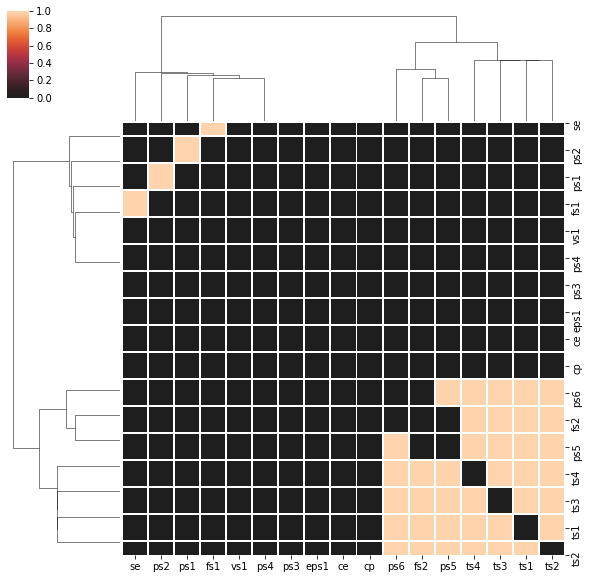

In [4]:
ax = sns.clustermap((feature_df.corr()>=.99)&(feature_df.corr()!= 1)
                    |(feature_df.corr()<=-.99)&(feature_df.corr()!= 1)
                    ,center=0
                    ,linewidths=.9
                    ,figsize=(10, 10)) 

In [5]:
feature_labels = feature_df.corr()[(feature_df.corr()>=.98)
                                   &(feature_df.corr()!= 1)
                                   |(feature_df.corr()<=-.98)
                                   &(feature_df.corr()!= 1)].dropna(axis=0,how='all').dropna(axis=1,how='all').round(4)
feature_labels = feature_labels.where((pd.notnull(feature_labels)), "")

feature_labels

,fs1,fs2,ps1,ps2,ps5,ps6,se,ts1,ts2,ts3,ts4
fs1,,,,,,,0.9946,,,,
fs2,,,,,,,,-0.9947,-0.9931,-0.9963,-0.9914
ps1,,,,0.9953,,,,,,,
ps2,,,0.9953,,,,,,,,
ps5,,,,,,1,,-0.9927,-0.9929,-0.9914,-0.9951
ps6,,,,,1,,,-0.9925,-0.9928,-0.9912,-0.9949
se,0.9946,,,,,,,,,,
ts1,,-0.9947,,,-0.9927,-0.9925,,,0.9993,0.9997,0.9992
ts2,,-0.9931,,,-0.9929,-0.9928,,0.9993,,0.9991,0.9983
ts3,,-0.9963,,,-0.9914,-0.9912,,0.9997,0.9991,,0.9984


In [6]:
# Selecting high correlated groups
corr_groups = []

for col in feature_df.columns:
    list = feature_df.columns[(((feature_df.corr()[col]>=.9) 
                                | (feature_df.corr()[col]<= -.9))).values].tolist()
    #print(list)
    if list not in corr_groups and len(list)>1:
        corr_groups.append(list)

In [7]:
#add feature groups for estimation
groups_to_add = [["ps1", "ps2", "ps3"], 
                 ["ps5", "ps6"], 
                 ["ts1", "ts2", "ts3", "ts4"], ["ts4", "fs2"]]

for i in groups_to_add:
    corr_groups.append(i)

In [8]:
def OLS_loop_group(feature_cols, target_cols):
    df = mean_df.copy()

    X = df[feature_cols]
    X = sm.add_constant(X)
    Y = df[target_cols]
    model = sm.OLS(Y, X)
    results = model.fit()
    return model.fit()

In [9]:
corr_groups_hight = []

for i in corr_groups:
    r_val = OLS_loop_group(i[:-1], i[-1]).rsquared_adj
    p_val = OLS_loop_group(i[:-1], i[-1]).pvalues
    if r_val >.95 and any(p_val<.05)==1: #get groups with hight R^2 and low p-value
        corr_groups_hight.append(i)
        results = OLS_loop_group(i[:-1], i[-1])

# Multiple Linear Regression (Sklearn)

In [10]:
# Loop through groups with high correlation
for group in corr_groups_hight:
    features_select = feature_df[group]
    for target in target_df:
        X = feature_df[group]
        Y = target_df[target]
        model = LinearRegression()
        lin_reg = model.fit(X, Y)
        y_pred = model.predict(X)
        
        if lin_reg.score(X, Y) > .9:
            rmsq = np.sqrt(metrics.mean_squared_error(Y, y_pred)).round(2)
            masqr = metrics.mean_absolute_error(Y, y_pred)
            Y_mean = Y.mean()
            print("Selected Features: ", group, "\nSelected Target: ", target)
            print('Score Train: ' + str(lin_reg.score(X, Y).round(4)))
            print('Mean Absolute Error:', masqr.round(2), "(Perc of Y mean:", round(masqr/Y_mean*100, 1),"*)" ) 
            print('Root Mean Squared Error:', rmsq, "(Perc of Y mean:", round(rmsq/Y_mean*100, 1),"*)" )
            print("--------")

Selected Features:  ['ce', 'cp', 'fs2', 'ps5', 'ps6', 'ts1', 'ts2', 'ts3', 'ts4'] 
Selected Target:  cooler_condition
Score Train: 0.9951
Mean Absolute Error: 1.6 (Perc of Y mean: 3.9 *)
Root Mean Squared Error: 2.98 (Perc of Y mean: 7.2 *)
--------
Selected Features:  ['ce', 'cp', 'ps5', 'ps6', 'ts1', 'ts2', 'ts3', 'ts4'] 
Selected Target:  cooler_condition
Score Train: 0.9951
Mean Absolute Error: 1.59 (Perc of Y mean: 3.9 *)
Root Mean Squared Error: 2.98 (Perc of Y mean: 7.2 *)
--------
Selected Features:  ['fs1', 'ps1', 'ps2', 'ps3', 'se'] 
Selected Target:  cooler_condition
Score Train: 0.9618
Mean Absolute Error: 5.39 (Perc of Y mean: 13.1 *)
Root Mean Squared Error: 8.28 (Perc of Y mean: 20.1 *)
--------
Selected Features:  ['fs1', 'ps1', 'ps2', 'ps3', 'se'] 
Selected Target:  valve_condition
Score Train: 0.946
Mean Absolute Error: 2.03 (Perc of Y mean: 2.2 *)
Root Mean Squared Error: 2.48 (Perc of Y mean: 2.7 *)
--------
Selected Features:  ['fs1', 'ps1', 'ps2', 'se'] 
Selected 

[* Perc of Y mean higher 10%: algorithm was not very accurate]